In [1]:
import pandas as pd
import json
from utils.deal import mkdir
input_dir = '/mnt/raid7/Dachuang/Achuan/03_phage_host/01_CRISPR/07_score'
output_dir = '/mnt/raid7/Dachuang/Achuan/03_phage_host/01_CRISPR/08_analysis'
mkdir(output_dir)
df_result = pd.read_table(f'{input_dir}/all_score_filtered_tag.tsv')
# df_blastn.columns=['GEM_id','virus_id']
# add taxonmy information according GEM_id
gcf_dict = json.load(
    open('/mnt/raid7/Dachuang/Achuan/03_phage_host/db/gcf_dict.json'))

df_result["taxonomy"] = df_result.apply(
    lambda x: gcf_dict[x['host']], axis=1)

df_result.to_csv(f'{output_dir}/result_taxonomy.tsv', sep='\t', index=False)


In [2]:
# 了解virus 长度分布
virus_host_dict = json.load(
    open(f'/mnt/raid7/Dachuang/Achuan/03_phage_host/db/gold_virus_info.json'))
virus_length_dict=json.load(open(f'/mnt/raid7/Dachuang/Achuan/03_phage_host/db/Virus_seqlen.json'))


In [3]:
import pandas as pd
df_result = pd.read_table(f'{output_dir}/result_taxonomy.tsv')
df_result
# calcute the most common host taxon for each virus
# df_result.groupby('virus_id').agg({'taxonomy':'count'}).sort_values(by='taxonomy',ascending=False)


,host,virus,score,rank,species_tag,genus_tag,taxonomy
0,GCF_000007005.1,NC_023585.1,2.3,1,1,1,k__Archaea;p__Crenarchaeota;c__Thermoprotei;o_...
1,GCF_000007005.1,NC_034620.1,1.4,1,0,0,k__Archaea;p__Crenarchaeota;c__Thermoprotei;o_...
2,GCF_000007005.1,NC_034625.1,1.2,2,0,0,k__Archaea;p__Crenarchaeota;c__Thermoprotei;o_...
3,GCF_000007005.1,NC_034623.1,1.1,1,0,0,k__Archaea;p__Crenarchaeota;c__Thermoprotei;o_...
4,GCF_000007005.1,NC_034619.1,1.1,1,0,0,k__Archaea;p__Crenarchaeota;c__Thermoprotei;o_...
...,...,...,...,...,...,...,...
168,GCF_903886475.1,NC_002185.1,1.1,1,1,1,k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...
169,GCF_903886475.1,NC_004303.1,1.1,1,1,1,k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...
170,GCF_903886475.1,NC_031069.1,1.1,1,1,1,k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...
171,GCF_903886475.1,NC_022776.1,1.1,1,1,1,k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...


## 生成virus host.json

In [4]:
from collections import Counter
import json
virus_dict = {}
with open(f'{output_dir}/result_taxonomy.tsv', 'r') as f:
    # 跳过下一行
    f.readline()
    for line in f:
        line = line.strip().split('\t')
        virus_id = line[1]
        host_num = 1
        host_info = {'host_id': line[0],
                     'host_lineage': line[-1]}
        if virus_id not in virus_dict:
            virus_dict[virus_id] = {
                'host_num': host_num, 'host_info': [host_info], 'true_host_lineage': virus_host_dict[virus_id.split(".")[0]]["split_lineage"] }
        else:
            virus_dict[virus_id]['host_num'] += 1
            virus_dict[virus_id]['host_info'].append(host_info)


# 初始化一个字典，用来存放每个索引的taxonomy level
taxonomy_level = {6: 'species', 5: 'genus',
                  4: 'family', 3: 'order', 2: 'class', 1: 'phylum', 0: 'kingdom'}
for virus_id in virus_dict:
    lca_flag=False
    virus_info = virus_dict[virus_id]
    host_num = virus_info['host_num']
    virus_dict[virus_id]['lca_info'] = {}
    virus_dict[virus_id]['most_common_taxonomy'] = {}
    virus_dict[virus_id]['purity'] = {}
    # 先把每个病毒的host lineage合并为表格，方便后面统计
    lineage_list = [host_info['host_lineage']
                    for host_info in virus_info['host_info']]
    # 从右往左数，获取各个层级的最多相同次数，一旦哪个最多相同次数为host num数就是LCA level
    for i in taxonomy_level.keys():
        taxonomy_list = sorted([lineage.split(';')[i].split('__')[1]
                         for lineage in lineage_list], reverse=True) # reverse=True表示为了让空的排后面
            
        maxcounttax = Counter(taxonomy_list).most_common(1)[0][0]
        maxcount = Counter(taxonomy_list).most_common(1)[0][1]
        # 计算purity
        purity = round(maxcount / host_num*100, 2)
        level = taxonomy_level[i]
        virus_dict[virus_id]['purity'][level] = purity
        # 保存maxcounttax
        virus_dict[virus_id]['most_common_taxonomy'][level] = maxcounttax
        # 计算lca
        if not lca_flag and maxcount == host_num and maxcounttax:
            lca_level = taxonomy_level[i]
            lca_name = maxcounttax
            lca_lineage = ';'.join(lineage_list[0].split(';')[:i+1])
            lca_flag = True

    # 把LCA 信息补充放入字典
    virus_dict[virus_id]['lca_info']['lca_level'] = lca_level
    virus_dict[virus_id]['lca_info']['lca_name'] = lca_name
    virus_dict[virus_id]['lca_info']['lca_lineage'] = lca_lineage


In [5]:
json.dump(virus_dict, open(
    f'{output_dir}/virus_host.json', 'w'), indent=4)


## 计算precision

In [6]:
taxonomy_level = {0: 'kingdom', 1: 'phylum', 2: 'class',
                  3: 'order', 4: 'family', 5: 'genus', 6: 'species'}


def cal_acc(virusid, lineage, i):
    prediction = lineage.split(';')[i].split("__")[1]
    level = taxonomy_level[i]
    if virusid in virus_host_dict:
        if prediction in virus_host_dict[virusid]['split_lineage'][level]:
            return True
    return False


df_result['virus'] = df_result['virus'].apply(lambda x: x.split('.')[0])
acc = {'kingdom': 0, 'phylum': 0, 'class': 0,
       'order': 0, 'family': 0, 'genus': 0, 'species': 0}
for i in taxonomy_level:
    level = taxonomy_level[i]
    acc[level] = sum(df_result.apply(lambda x: cal_acc(
        x['virus'], x['taxonomy'], i), axis=1))
df_acc = pd.DataFrame(acc, index=['count']).T
df_acc['precision'] = round(df_acc['count']/len(df_result), 4)
df_acc


,count,precision
kingdom,173,1.0000
phylum,173,1.0000
class,173,1.0000
order,173,1.0000
family,170,0.9827
genus,139,0.8035
species,120,0.6936


In [7]:
sum(df_result.apply(lambda x: cal_acc(
    x['virus'], x['taxonomy'], 2), axis=1))


173

## 尝试用most common taxon来评估

In [8]:
# 计算species水平的准确度
species_precison = 0
for virus_id in virus_dict:
    virus_info = virus_dict[virus_id]
    most_common_taxonomy = virus_info['most_common_taxonomy']["species"]
    if most_common_taxonomy in virus_info["true_host_lineage"]["species"]:
        species_precison += 1


def cal_precison(level, virus_dict):
    precison_num = 0
    for virus_id in virus_dict:
        virus_info = virus_dict[virus_id]
        most_common_taxonomy = virus_info['most_common_taxonomy'][level]
        if most_common_taxonomy in virus_info["true_host_lineage"][level]:
            precison_num += 1
    return precison_num
# def cal_acc(virusid, lineage, i):
#     prediction = lineage.split(';')[i]
#     level = taxonomy_level[i]
#     if virusid in virus_host_dict:
#         if prediction in virus_host_dict[virusid]['split_lineage'][level]:
#             return True
#     return False


acc = {'kingdom': 0, 'phylum': 0, 'class': 0,
       'order': 0, 'family': 0, 'genus': 0, 'species': 0}
for i in taxonomy_level:
    level = taxonomy_level[i]
    acc[level] = cal_precison(level, virus_dict)
df_pre = pd.DataFrame(acc, index=['count']).T
df_pre['precison'] = round(df_pre['count']/len(virus_dict), 4)
df_pre.to_csv(
    f'/mnt/raid7/Dachuang/Achuan/03_phage_host/analysis_data/08_common_vs_score/spacer_common.csv')

df_pre


,count,precison
kingdom,145,1.0000
phylum,145,1.0000
class,145,1.0000
order,145,1.0000
family,142,0.9793
genus,118,0.8138
species,106,0.7310


In [9]:
# save purity result
table = []
for virus_id in virus_dict.keys():
    virus_info = virus_dict[virus_id]
    line_dict = {"virus_id": virus_id, 'host_num': virus_info['host_num'],
                 'kingdom': virus_info['purity']['kingdom'], 
                'phylum': virus_info['purity']['phylum'],
                'class': virus_info['purity']['class'],
                'order': virus_info['purity']['order'],
                'family': virus_info['purity']['family'],
                'genus': virus_info['purity']['genus'],
                'species': virus_info['purity']['species'],
                 }
    table.append(line_dict)

df_purity = pd.DataFrame(table)
df_purity.to_csv(
    f'{output_dir}/virus_purity.tsv', sep='\t', index=False)


In [10]:
txt = df_purity.drop(['virus_id', 'host_num'], axis=1).mean().round(2)
df_ = pd.DataFrame({'Item': txt.index, 'Mean': txt.values})
df_.to_csv(f'{output_dir}/virus_purity_mean.tsv', sep='\t', index=False)
df_

,Item,Mean
0,kingdom,100.00
1,phylum,100.00
2,class,100.00
3,order,100.00
4,family,100.00
5,genus,98.62
6,species,96.44


## LCA分析

In [11]:
table = []
for virus_id in virus_dict.keys():
    virus_info = virus_dict[virus_id]
    line_dict = {"virus_id": virus_id, 'host_num': virus_info['host_num'],
                 'lca_level': virus_info['lca_info']['lca_level'], 'lca_name': virus_info['lca_info']['lca_name'], 'lca_lineage': virus_info['lca_info']['lca_lineage']}
    table.append(line_dict)

df_virus = pd.DataFrame(table)
df_virus.to_csv(
    f'{output_dir}/virus_lca.tsv', sep='\t', index=False)
df_virus


,virus_id,host_num,lca_level,lca_name,lca_lineage
0,NC_023585.1,3,family,Sulfolobaceae,k__Archaea;p__Crenarchaeota;c__Thermoprotei;o_...
1,NC_034620.1,2,species,Saccharolobus solfataricus,k__Archaea;p__Crenarchaeota;c__Thermoprotei;o_...
2,NC_034625.1,3,family,Sulfolobaceae,k__Archaea;p__Crenarchaeota;c__Thermoprotei;o_...
3,NC_034623.1,2,family,Sulfolobaceae,k__Archaea;p__Crenarchaeota;c__Thermoprotei;o_...
4,NC_034619.1,1,species,Saccharolobus solfataricus,k__Archaea;p__Crenarchaeota;c__Thermoprotei;o_...
...,...,...,...,...,...
140,NC_002185.1,1,species,Streptococcus thermophilus,k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...
141,NC_004303.1,1,species,Streptococcus thermophilus,k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...
142,NC_031069.1,1,species,Streptococcus thermophilus,k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...
143,NC_022776.1,1,species,Streptococcus thermophilus,k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...


In [12]:
# calculate species host
from collections import Counter
for virus_id in virus_dict:
    virus_info = virus_dict[virus_id]
    host_info = virus_info['host_info']
    species_host_list = []
    for host in host_info:
        species_host = host['host_lineage'].split(';')[6].strip()
        if species_host not in species_host_list:
            species_host_list.append(species_host)
    virus_info['species_host_num'] = len(species_host_list)
json.dump(virus_dict, open(
    f'{output_dir}/virus_host.json', 'w'), indent=4)

# 统计species num
species_num_list = []
for virus_id in virus_dict:
    virus_info = virus_dict[virus_id]
    species_host_num = virus_info['species_host_num']
    species_num_list.append(species_host_num)

counts_dict = Counter(species_num_list)
word_counts = sorted(counts_dict.items(), key=lambda x: x[0], reverse=False)
counts_dict = dict(word_counts)
report_dict = {}
others_count = 0
for i in counts_dict.keys():
    if i < 7:
        report_dict[i] = counts_dict[i]
    else:
        others_count += counts_dict[i]
report_dict["other(>=7)"] = others_count


df_ = pd.DataFrame({'Host Num': report_dict.keys(),
                   'Count': report_dict.values()})
df_['Percent'] = (df_['Count']/df_['Count'].sum()).round(4)
df_.to_csv(f'{output_dir}/virus_host_num.tsv', sep='\t', index=False)
df_


,Host Num,Count,Percent
0,1,135,0.9310
1,2,6,0.0414
2,3,4,0.0276
3,other(>=7),0,0.0000


In [13]:
df_virus['host_num'].describe()


count    145.000000
mean       1.193103
std        0.504102
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        3.000000
Name: host_num, dtype: float64

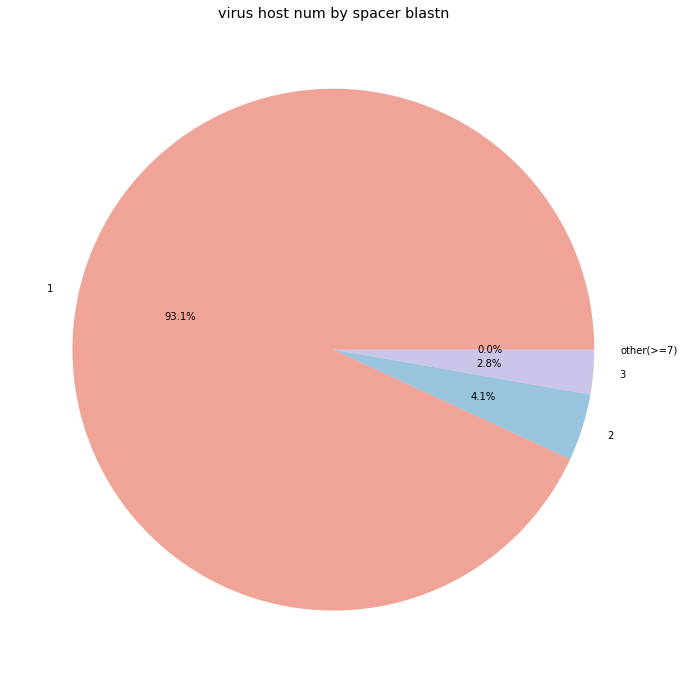

In [14]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.figure(figsize=(12, 12))
size = df_["Count"]  # 数据
label =df_["Host Num"]  # 标签
plt.pie(size, labels=label, autopct='%.1f%%',wedgeprops={'alpha':0.5})
plt.title('virus host num by spacer blastn')
# save svg
plt.savefig(f'{output_dir}/virus_host_num.svg')


In [15]:
# 统计lca_level
txt = df_virus['lca_level'].value_counts()
df_ = pd.DataFrame({'Tax level': txt.index, 'Count': txt.values})
df_['Percent'] = (df_['Count']/df_['Count'].sum()).round(4)
df_.to_csv('/mnt/raid7/Dachuang/Achuan/03_phage_host/analysis_data/07_lca/spacer.tsv',
           sep='\t', index=False)
df_


,Tax level,Count,Percent
0,species,135,0.9310
1,family,5,0.0345
2,genus,5,0.0345


In [16]:
# 统计lca_name
txt = df_virus['lca_name'].value_counts()
df_ = pd.DataFrame({'Tax name': txt.index, 'Count': txt.values})
df_['Percent'] = (df_['Count']/df_['Count'].sum()).round(4)
# df_.to_csv('virushostdb.daily.phage.lca.name.tsv', sep='\t', index=False)
df_

,Tax name,Count,Percent
0,Paenibacillus larvae,16,0.1103
1,Pseudomonas aeruginosa,12,0.0828
2,Klebsiella pneumoniae,9,0.0621
3,Streptococcus thermophilus,6,0.0414
4,Mannheimia haemolytica,6,0.0414
5,Salmonella enterica,6,0.0414
6,Listeria monocytogenes,5,0.0345
7,Streptococcus dysgalactiae,5,0.0345
8,Saccharolobus solfataricus,5,0.0345
9,Sulfolobus islandicus,5,0.0345


## tax分析

In [17]:
def get_lineage_rank(x, rank):
    taxonomy_level = {'strain': 7, 'species': 6, 'genus': 5,
                      'family': 4, 'order': 3, 'class': 2, 'phylum': 1, 'kingdom': 0}
    i = taxonomy_level[rank]
    try:
        return x.split(';')[i].split('__')[1]
    except:
        return '-'


df_lca = df_virus

f = open(f'{output_dir}/lca.lineage.md', 'w')

# kindom
txt=df_lca['lca_lineage'].apply(lambda x: get_lineage_rank(x,'kingdom')).value_counts()
df_ = pd.DataFrame({'kingdom':txt.index, 'Count':txt.values})
df_['Percent'] = (df_['Count']/df_['Count'].sum()).round(4)
f.write('## kingdom\n')
f.write(df_.to_csv(sep='\t',index=False))
# phylum
txt=df_lca['lca_lineage'].apply(lambda x: get_lineage_rank(x,'phylum')).value_counts()
df_ = pd.DataFrame({'phylum':txt.index, 'Count':txt.values})
df_['Percent'] = (df_['Count']/df_['Count'].sum()).round(4)
f.write('## phylum\n')
f.write(df_.to_csv(sep='\t',index=False))

# class
txt=df_lca['lca_lineage'].apply(lambda x: get_lineage_rank(x,'class')).value_counts()
df_ = pd.DataFrame({'class':txt.index, 'Count':txt.values})
df_['Percent'] = (df_['Count']/df_['Count'].sum()).round(4)
f.write('## class\n')
f.write(df_.to_csv(sep='\t',index=False))

# order
txt=df_lca['lca_lineage'].apply(lambda x: get_lineage_rank(x,'order')).value_counts()
df_ = pd.DataFrame({'order':txt.index, 'Count':txt.values})
df_['Percent'] = (df_['Count']/df_['Count'].sum()).round(4)
f.write('## order\n')
f.write(df_.to_csv(sep='\t',index=False))

# family
txt=df_lca['lca_lineage'].apply(lambda x: get_lineage_rank(x,'family')).value_counts()
df_ = pd.DataFrame({'family':txt.index, 'Count':txt.values})
df_['Percent'] = (df_['Count']/df_['Count'].sum()).round(4)
f.write('## family\n')
f.write(df_.to_csv(sep='\t',index=False))


# genus
txt=df_lca['lca_lineage'].apply(lambda x: get_lineage_rank(x,'genus')).value_counts()
df_ = pd.DataFrame({'genus':txt.index, 'Count':txt.values})
df_['Percent'] = (df_['Count']/df_['Count'].sum()).round(4)
f.write('## genus\n')
f.write(df_.to_csv(sep='\t',index=False))


# species
txt=df_lca['lca_lineage'].apply(lambda x: get_lineage_rank(x,'species')).value_counts()
df_ = pd.DataFrame({'species':txt.index, 'Count':txt.values})
df_['Percent'] = (df_['Count']/df_['Count'].sum()).round(4)
f.write('## species\n')
f.write(df_.to_csv(sep='\t',index=False))


# strain
txt=df_lca['lca_lineage'].apply(lambda x: get_lineage_rank(x,'strain')).value_counts()
df_ = pd.DataFrame({'strain':txt.index, 'Count':txt.values})
df_['Percent'] = (df_['Count']/df_['Count'].sum()).round(4)
f.write('## strain\n')
f.write(df_.to_csv(sep='\t',index=False))
f.close()
